In [4]:
from PIL import Image
import importlib
import time
import utils.dataset_process as dataset_process
importlib.reload(dataset_process)
from utils.dataset_process import *
from recrop_images import Recropper

In [5]:
# parse args
args = parse_args()

# initialize detectors
hdet = YoloHeadDetector(weights_file='assets/224x224_yolov4_hddet_480x640.onnx',
                        input_width=640, input_height=480)
fdet = FaceAlignmentDetector()
recropper = Recropper()

# some constants
vis_samples = 10
data_path = args.data_path
assert os.path.exists(data_path), 'data path does not exist'

# output configs
data_name = os.path.basename(data_path)
out_json_name = data_name + '_stat.json'
out_json_path = os.path.join(args.output_dir, out_json_name)


/home/shitianhao/project/DatProc/TDDFA_V2/TDDFA.py


In [6]:
# search through dataset dir and get all image formats
extensions = get_all_extensions(data_path)
print(f'Found extensions: {extensions}')
IMG_FORMATS = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp", ".svg", ".ico", ".exif", ".raw", ".heic", ".jfif", ".tga", ".pdf", ".eps", ".ai", ".psd"]
extensions = list(set(extensions).intersection(set(IMG_FORMATS)))
print(f'Found image extensions: {extensions}')


Found extensions: {'.png', '.jpg'}
Found image extensions: ['.png', '.jpg']


  0%|          | 0/5 [00:00<?, ?it/s]

0.8019963
0.84906775
0.77895254
Score is too low!


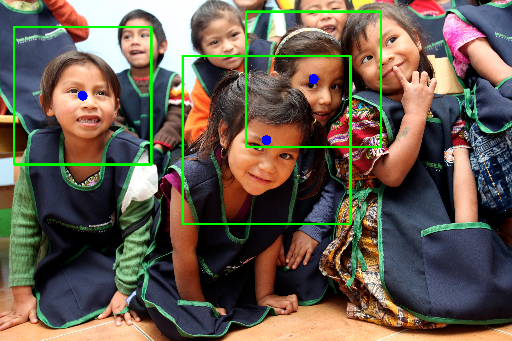

 20%|██        | 1/5 [01:57<07:48, 117.10s/it]

0.86151165
0.86442536
0.8397066


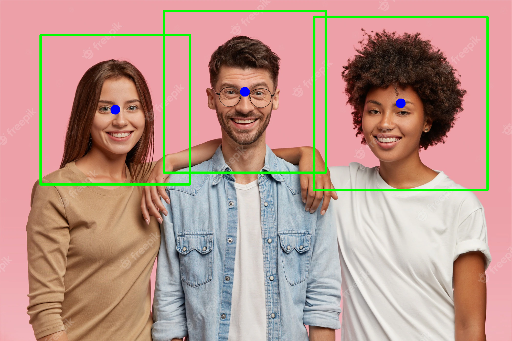

 40%|████      | 2/5 [02:01<02:32, 50.79s/it] 

0.8392246
0.8539014


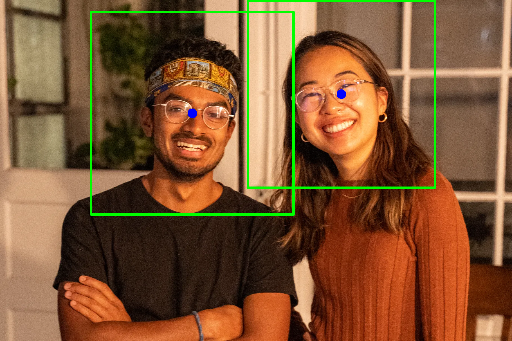

100%|██████████| 5/5 [02:04<00:00, 24.99s/it]


In [8]:
img_paths = get_images(data_path, extensions)
is_small = lambda w, h, min_size=512: w < min_size or h < min_size
for img_path in tqdm(img_paths):
    img = cv2.imread(img_path)
    if img is None: continue # filter invalid images
    img_h, img_w = img.shape[:2]
    if is_small(img_h, img_w): continue # filter small images
    image_boxes = hdet(img.copy(), isBGR=True)
    if image_boxes.shape[0] == 0: continue # filter images without boxes
    vis_image = img.copy()
    vis_w, vis_h = vis_image.shape[:2]
    vis_scale = 512/vis_h
    for box in image_boxes:
        box_x, box_y, box_w, box_h = box
        ur = np.array([box_x, box_y])
        cx, cy = box_x + box_w/2, box_y + box_h/2
        vis_image = cv2.circle(vis_image, (int(cx), int(cy)), int(5/vis_scale), (255, 0, 0), -1) # bgr
        vis_image = cv2.rectangle(vis_image, (int(box_x), int(box_y)), (int(box_x+box_w), int(box_y+box_h)), (0, 255, 0), int(2/vis_scale)) # bgr
        box_image = img[int(box_y):int(box_y+box_h), int(box_x):int(box_x+box_w)].copy()
        landmarks = fdet(box_image, True)
        if landmarks is None: continue # filter boxes with failed face detection
        recropper(box_image, landmarks)
        # for pt in landmarks:
        #     pt = pt.astype(np.int16)
        #     cv2.circle(vis_image, pt, int(2/vis_scale), [0, 255, 0], -1)
    vis_image_ = cv2.resize(vis_image.copy(), (0, 0), fx=vis_scale, fy=vis_scale)
    display(Image.fromarray(vis_image_[..., ::-1]))
